# Detecting COVID-19 & Viral Pneumonia in X-Ray Images

Dataset from: https://www.kaggle.com/tawsifurrahman/covid19-radiography-database?


Also using COVID-19 X-Rays from https://www.kaggle.com/nabeelsajid917/covid-19-x-ray-10000-images?

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf 
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from random import shuffle
import random
import os

# Define Constants

In [95]:
path = 'C:\\Users\\frist\\OneDrive\Desktop\\COVID-19-X-Ray-Classification\\'

IMAGE_WIDTH = 200
IMAGE_HEIGHT = 200

IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

# Prepare Training Data

In [96]:
directories = ['train']
categories = []
    
files = os.listdir(path + directories[0])

for img in files:

    fileName = img.split('.')[0]
    
    if 'Normal' in fileName: categories.append(0)
    elif 'COVID' in fileName: categories.append(1)
    else: categories.append(2)


df = pd.DataFrame({
    'filename': files,
    'category': categories
})

In [64]:
df.head()

,filename,category
0,COVID-1.png,1
1,COVID-10.png,1
2,COVID-100.png,1
3,COVID-11.png,1
4,COVID-12.png,1


In [65]:
df.tail()

,filename,category
295,Viral Pneumonia-95.png,2
296,Viral Pneumonia-96.png,2
297,Viral Pneumonia-97.png,2
298,Viral Pneumonia-98.png,2
299,Viral Pneumonia-99.png,2


# Compare Frequencies 

<AxesSubplot:>

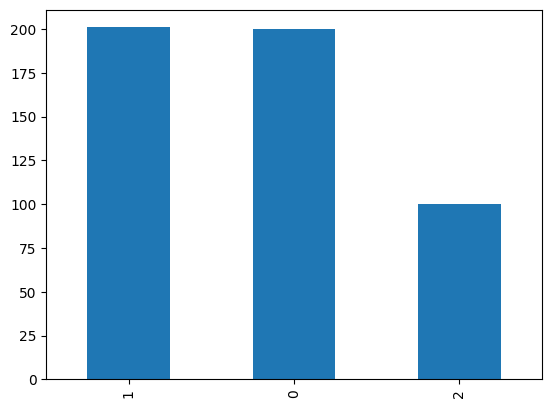

In [97]:
'''
0 Represents Normal 
1 Represents COVID-19
2 Represents Viral Pneumonia 
'''
df['category'].value_counts().plot.bar()

# Load Sample Image

COVID-33.png


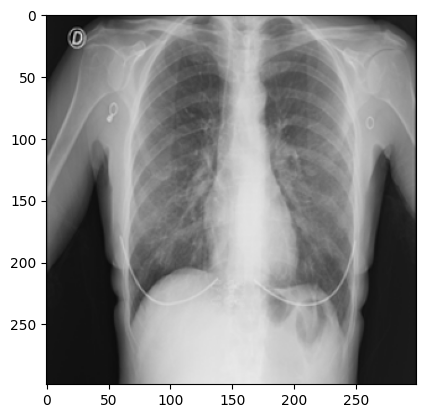

In [98]:
sample = random.choice(os.listdir(path + directories[0]))
image = tf.keras.preprocessing.image.load_img(path + '\\train\\' + sample)

print(sample)
plt.imshow(image)

# Build Model

1. **Input Layer**: This represents our input image data. It will reshape the image into a single dimensional array. For example, if your image is 64x64, it will convert to (4096,1) array (64x64 = 4096).


2. **Conv Layer**: This layer will extract features from image.


3. **Pooling Layer**: This layer will reduce the spatial volume of input image after convolution.


4. **Fully Connected Layer**: This will connect the network from a layer to another layer


5. **Output Layer**: This is the predicted values layer.

In [99]:
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Activation, Dropout, GlobalAveragePooling2D, \
    BatchNormalization, concatenate, AveragePooling2D
from keras.optimizers import Adam



def conv_layer(conv_x, filters):
    conv_x = BatchNormalization()(conv_x)
    conv_x = Activation('relu')(conv_x)
    conv_x = Conv2D(filters, (3, 3), kernel_initializer='he_uniform', padding='same', use_bias=False)(conv_x)
    conv_x = Dropout(0.2)(conv_x)

    return conv_x


def dense_block(block_x, filters, growth_rate, layers_in_block):
    for i in range(layers_in_block):
        each_layer = conv_layer(block_x, growth_rate)
        block_x = concatenate([block_x, each_layer], axis=-1)
        filters += growth_rate

    return block_x, filters


def transition_block(trans_x, tran_filters):
    trans_x = BatchNormalization()(trans_x)
    trans_x = Activation('relu')(trans_x)
    trans_x = Conv2D(tran_filters, (1, 1), kernel_initializer='he_uniform', padding='same', use_bias=False)(trans_x)
    trans_x = AveragePooling2D((2, 2), strides=(2, 2))(trans_x)

    return trans_x, tran_filters


def dense_net(filters, growth_rate, classes, dense_block_size, layers_in_block):
    input_img = Input(shape=(32, 32, 3))
    x = Conv2D(24, (3, 3), kernel_initializer='he_uniform', padding='same', use_bias=False)(input_img)

    dense_x = BatchNormalization()(x)
    dense_x = Activation('relu')(x)

    dense_x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(dense_x)
    for block in range(dense_block_size - 1):
        dense_x, filters = dense_block(dense_x, filters, growth_rate, layers_in_block)
        dense_x, filters = transition_block(dense_x, filters)

    dense_x, filters = dense_block(dense_x, filters, growth_rate, layers_in_block)
    dense_x = BatchNormalization()(dense_x)
    dense_x = Activation('relu')(dense_x)
    dense_x = GlobalAveragePooling2D()(dense_x)

    output = Dense(classes, activation='softmax')(dense_x)

    return Model(input_img, output)

In [41]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax', name='predictions')) 

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 198, 198, 32)      896       
                                                                 
 batch_normalization_6 (Batc  (None, 198, 198, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 99, 99, 32)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 99, 99, 32)        0         
                                                                 
 conv2d_27 (Conv2D)          (None, 97, 97, 64)        18496     
                                                                 
 batch_normalization_7 (Batc  (None, 97, 97, 64)      

# Callbacks

## Early Stop

To prevent overfitting, we will stop the learning after 10 epochs and if the val_loss value has not decreased

In [56]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)

# Learning Rate Reduction

We will reduce the learning rate when then accuracy does not increase for 2 steps

In [100]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', 
                                            patience = 2, 
                                            verbose = 1, 
                                            factor = 0.5, 
                                            min_lr = 0.00001)

callbacks = [earlystop, learning_rate_reduction]

In [101]:
df["category"] = df["category"].replace({0: 'Normal', 1: 'COVID', 2: 'Viral Pneumonia'}) 

# Shuffle Data

In [102]:
df = df.sample(frac=1).reset_index(drop=True)
df

,filename,category
0,COVID-129.png,COVID
1,COVID-89.png,COVID
2,Normal-102.png,Normal
3,Viral Pneumonia-79.png,Viral Pneumonia
4,COVID-181.png,COVID
...,...,...
496,Viral Pneumonia-75.png,Viral Pneumonia
497,Viral Pneumonia-53.png,Viral Pneumonia
498,Normal-100.png,Normal
499,Normal-197.png,Normal


In [103]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [86]:
#new
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['filename'], df['category'], test_size=0.2)
#Cat_test_y = np_utils.to_categorical(y_test)
#y_train=np_utils.to_categorical(y_train)

<AxesSubplot:>

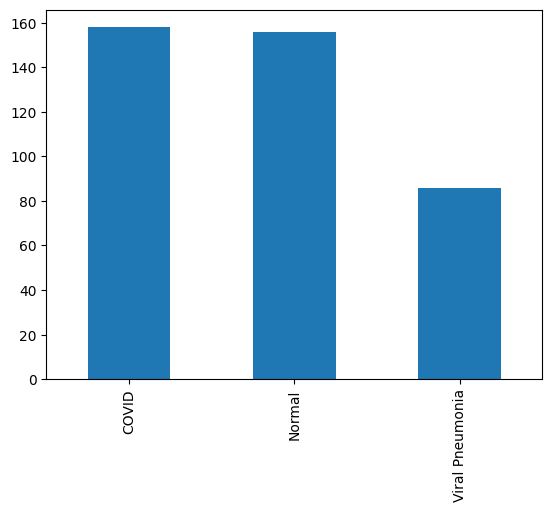

In [104]:
train_df['category'].value_counts().plot.bar()

<AxesSubplot:>

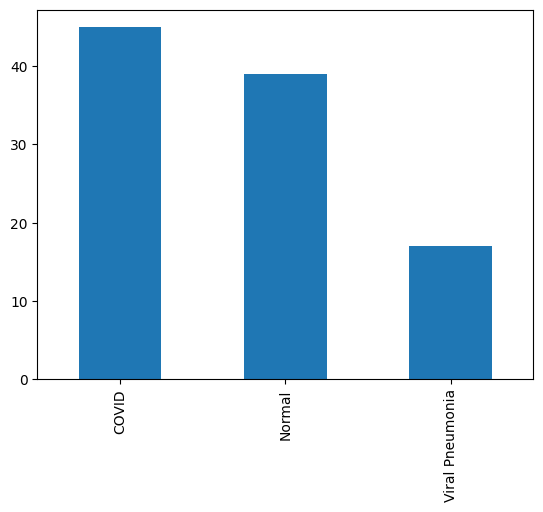

In [62]:
validate_df['category'].value_counts().plot.bar()

In [105]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size = 5

# Training Generator

In [106]:
train_datagen = ImageDataGenerator (
    
    rotation_range = 15,
    rescale = 1./255,
    
    shear_range = 0.1,
    zoom_range = 0.2,
    
    horizontal_flip = True,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

train_generator = train_datagen.flow_from_dataframe (
    
    train_df, 
    path + '\\train', 
    x_col = 'filename',
    y_col = 'category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = batch_size
)

Found 399 validated image filenames belonging to 3 classes.


c:\Users\frist\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\preprocessing\image.py:989: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


# Validation Generator

In [107]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe (
    
    validate_df, 
    path + '\\train', 
    x_col ='filename',
    y_col = 'category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = batch_size
)

Found 101 validated image filenames belonging to 3 classes.


# Visualize Generator 

In [108]:
example_df = train_df.sample(n=1).reset_index(drop=True)

example_generator = train_datagen.flow_from_dataframe (
    
    example_df, 
    path + '\\train', 
    x_col = 'filename',
    y_col = 'category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical'
)

Found 1 validated image filenames belonging to 1 classes.


        filename category
0  COVID-130.png    COVID


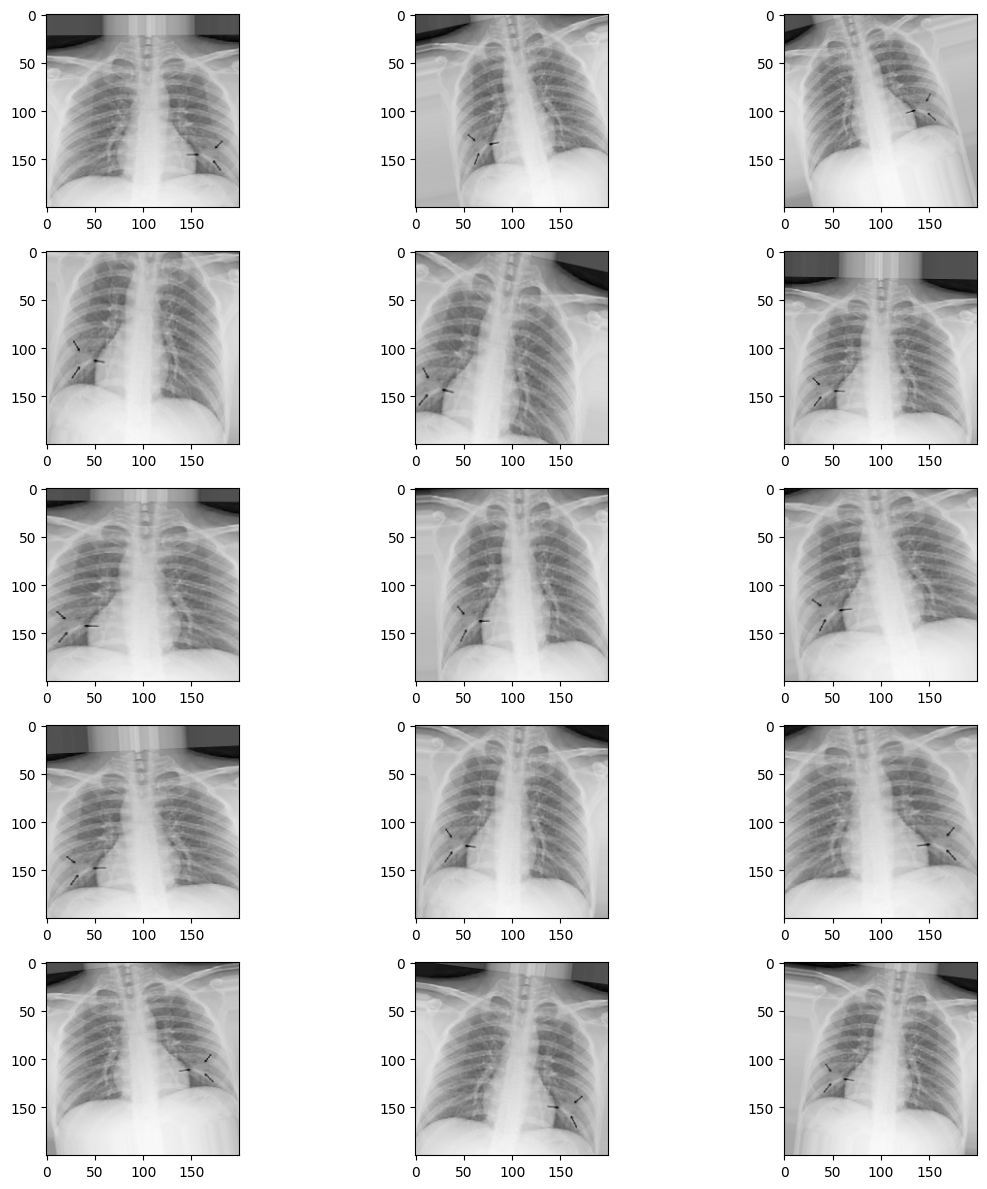

In [109]:
print(example_df)

plt.figure(figsize=(12, 12))

for i in range(0, 15):
    
    plt.subplot(5, 3, i+1)
    
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
        
plt.tight_layout()
plt.show()

In [110]:
#new
dense_block_size = 3
layers_in_block = 4

growth_rate = 12
classes = 3
model = dense_net(growth_rate * 2, growth_rate, classes, dense_block_size, layers_in_block)
model.summary()


# training
batch_size = 5
epochs = 10
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics=['accuracy'])
history=model.fit(train_generator, epochs=epochs, batch_size=batch_size, shuffle=True,validation_data=validation_generator)

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_106 (Conv2D)            (None, 32, 32, 24)   648         ['input_6[0][0]']                
                                                                                                  
 activation_80 (Activation)     (None, 32, 32, 24)   0           ['conv2d_106[0][0]']             
                                                                                                  
 max_pooling2d_18 (MaxPooling2D  (None, 16, 16, 24)  0           ['activation_80[0][0]']          
 )                                                                                          

c:\Users\frist\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


80/80 [==============================] - 52s 616ms/step - loss: 0.6334 - accuracy: 0.4486 - val_loss: 0.6651 - val_accuracy: 0.4257
Epoch 2/10
80/80 [==============================] - 49s 617ms/step - loss: 0.5511 - accuracy: 0.6466 - val_loss: 0.7377 - val_accuracy: 0.4257
Epoch 3/10
80/80 [==============================] - 50s 619ms/step - loss: 0.4962 - accuracy: 0.6792 - val_loss: 0.7669 - val_accuracy: 0.4257
Epoch 4/10
80/80 [==============================] - 49s 613ms/step - loss: 0.4930 - accuracy: 0.6842 - val_loss: 0.6384 - val_accuracy: 0.4356
Epoch 5/10
80/80 [==============================] - 49s 609ms/step - loss: 0.4811 - accuracy: 0.6667 - val_loss: 0.6273 - val_accuracy: 0.4455
Epoch 6/10
80/80 [==============================] - 48s 604ms/step - loss: 0.4733 - accuracy: 0.7118 - val_loss: 0.5334 - val_accuracy: 0.7129
Epoch 7/10
80/80 [==============================] - 50s 619ms/step - loss: 0.4535 - accuracy: 0.7293 - val_loss: 0.4451 - val_accuracy: 0.7921
Epoch 8/10

In [ ]:
epochs = 25

history = model.fit_generator (
    
    train_generator, 
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = total_validate//batch_size,
    steps_per_epoch = total_train//batch_size,
    callbacks = callbacks
)

In [128]:
model.save_weights("COVID-Model-Modified-{}-{}-{}-{}.h5".format(IMAGE_WIDTH, 3, batch_size, epochs))

# Visualize Training Performance 

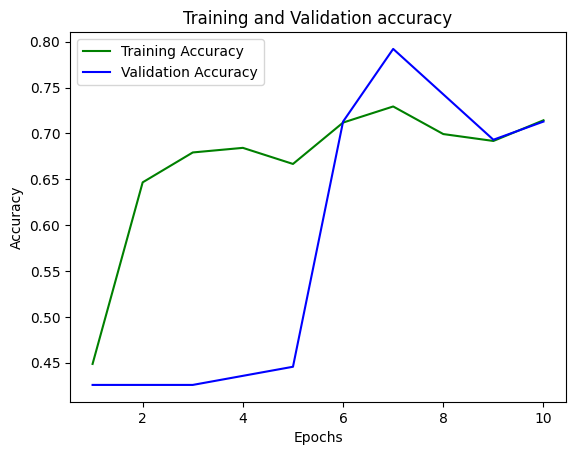

In [112]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
numEpochs = range(1,  epochs + 1)
plt.plot(numEpochs, accuracy, 'g', label='Training Accuracy')
plt.plot(numEpochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

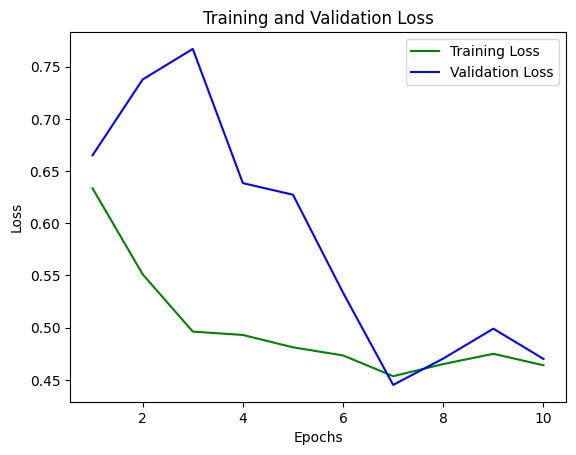

In [113]:
loss = history.history['loss']
val_loss = history.history['val_loss']
numEpochs = range(1,  epochs + 1)
plt.plot(numEpochs, loss, 'g', label='Training Loss')
plt.plot(numEpochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Prepare Testing Data

In [114]:
test_filenames = os.listdir(path + 'test')

test_df = pd.DataFrame({
    'filename': test_filenames
})

nb_samples = test_df.shape[0]

In [115]:
test_df = test_df.sample(frac=1).reset_index(drop=True)
test_df

,filename
0,COVID-109.png
1,Viral Pneumonia-112.png
2,Normal-105.png
3,Viral Pneumonia-110.png
4,Normal-101.png
5,Normal-104.png
6,Normal-107.png
7,Normal-103.png
8,Viral Pneumonia-109.png
9,COVID-104.png


# Create Testing Generator

In [116]:
test_gen = ImageDataGenerator(rescale = 1./255)
test_generator = test_gen.flow_from_dataframe(
    
    test_df, 
    path + '\\test', 
    x_col = 'filename',
    y_col = None,
    class_mode = None,
    target_size = IMAGE_SIZE,
    batch_size = batch_size,
    shuffle = False
)

Found 45 validated image filenames.


# Form Predictions

In [117]:
predict = model.predict_generator(test_generator, steps = np.ceil(nb_samples/batch_size))

C:\Users\frist\AppData\Local\Temp\ipykernel_25940\2670138283.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps = np.ceil(nb_samples/batch_size))


## Pick the category that has the highest probability 

In [118]:
test_df['category'] = np.argmax(predict, axis=-1)

In [119]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [120]:
test_df['category'] = test_df['category'].replace({'Normal': 0, 'COVID': 1, 'Viral Pneumonia': 2})

<AxesSubplot:>

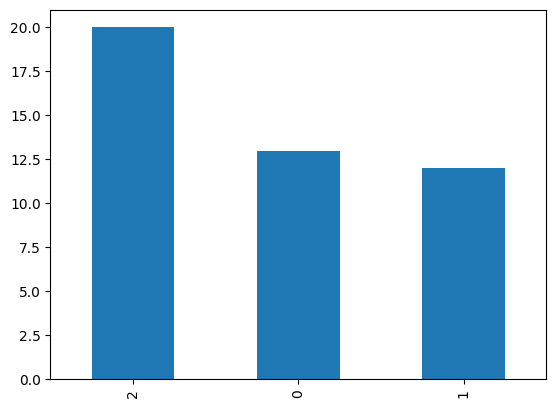

In [121]:
test_df['category'].value_counts().plot.bar()

# Predicted result with images

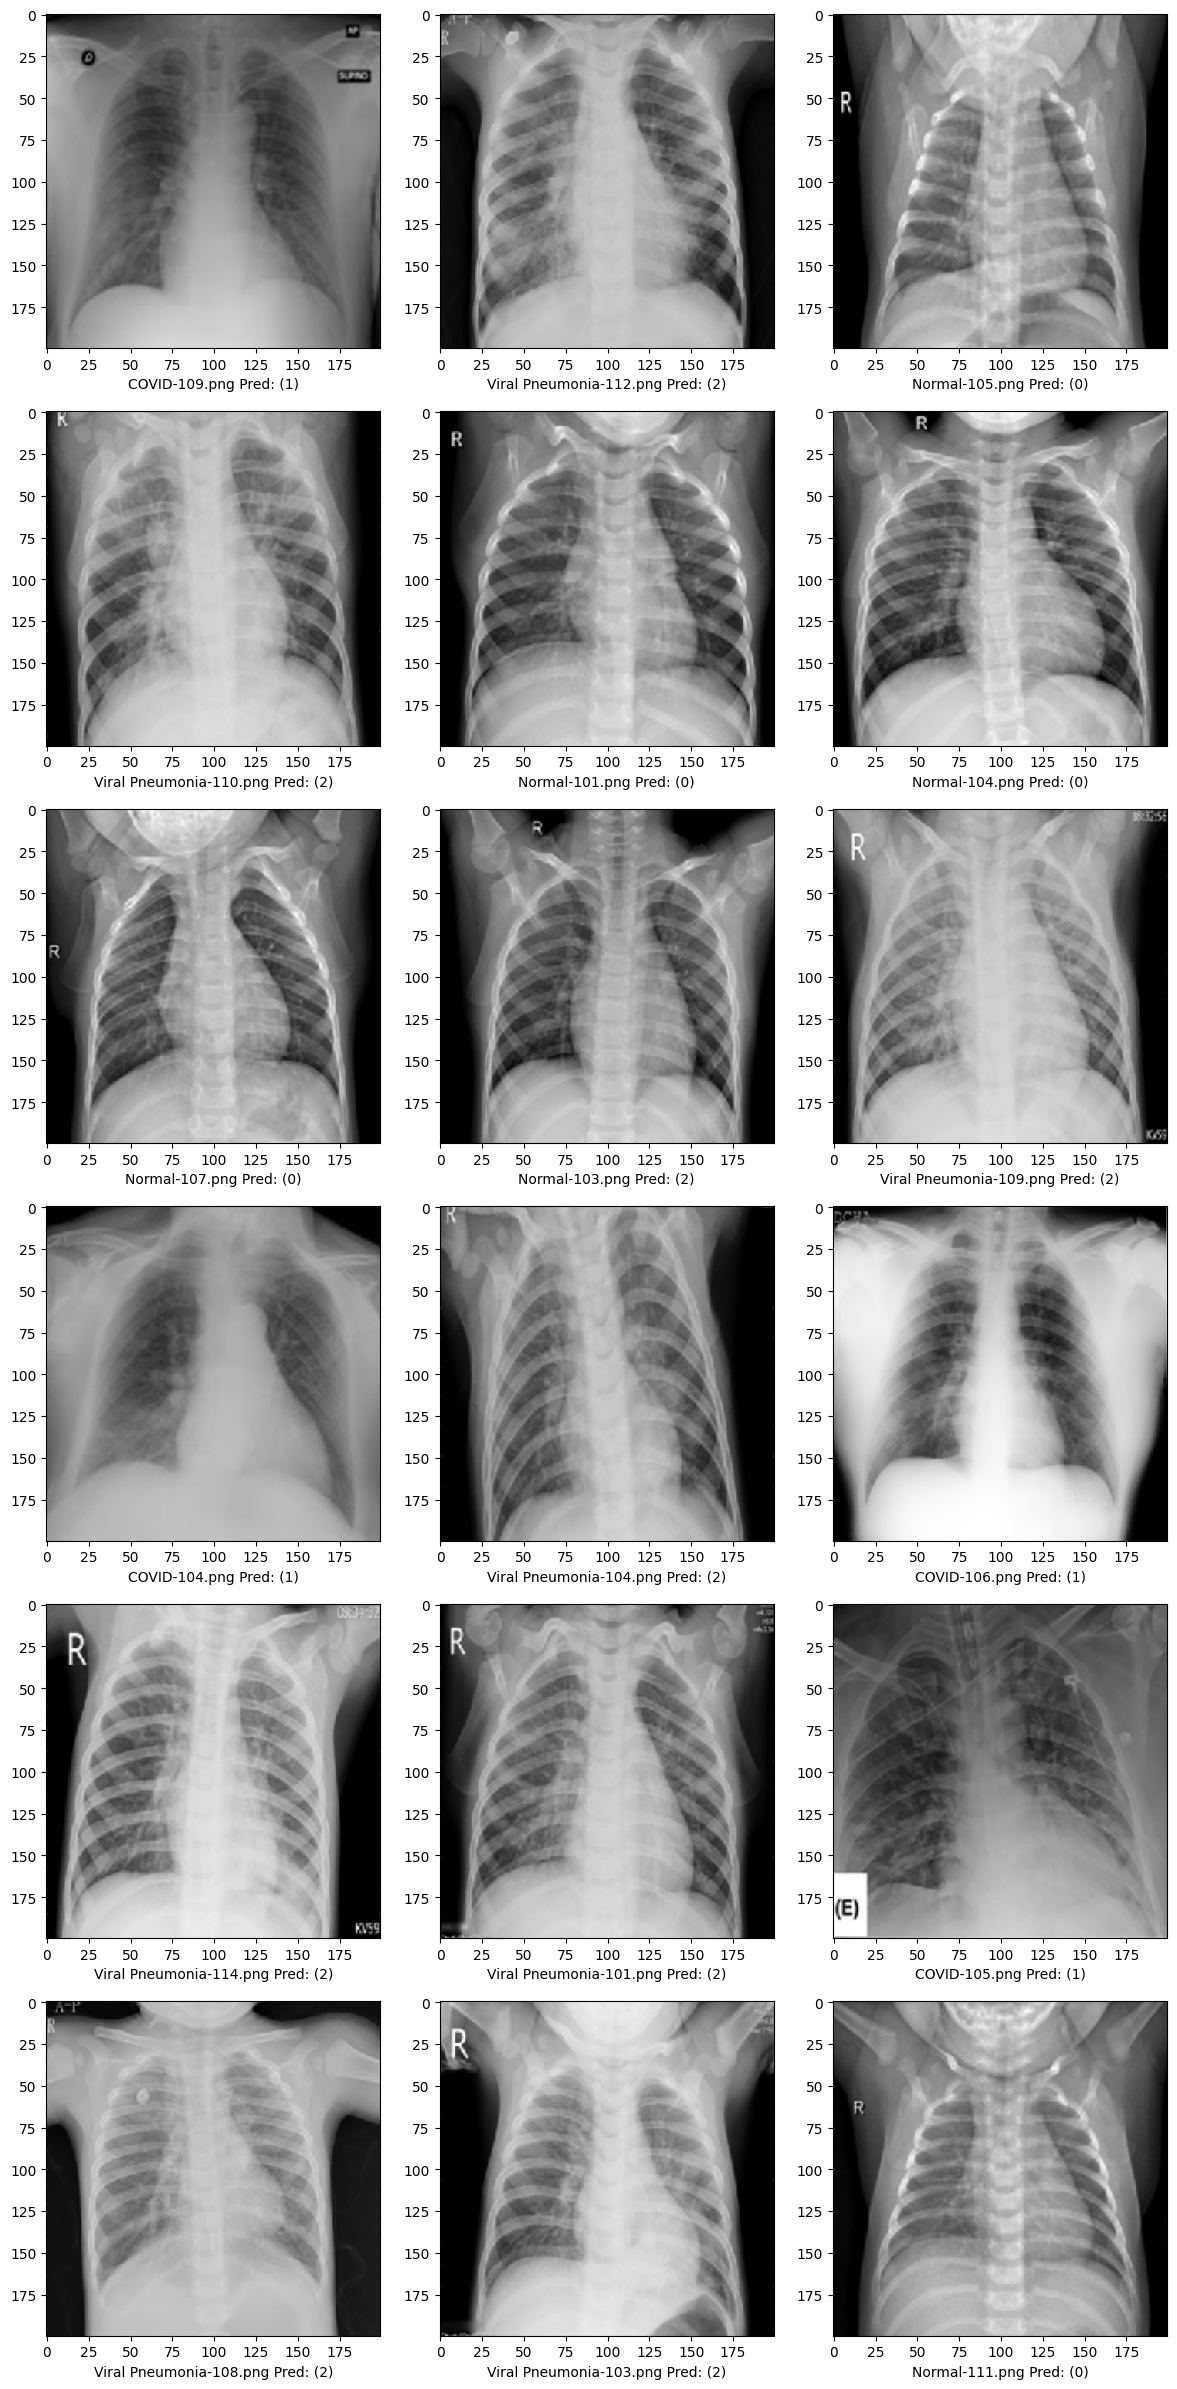

In [122]:
sample_test = test_df.head(18)
sample_test.head()

plt.figure(figsize=(12, 24))

for index, row in sample_test.iterrows():
    
    filename = row['filename']
    category = row['category']
    
    img = tf.keras.preprocessing.image.load_img(path + 'test\\' + filename, target_size=IMAGE_SIZE)
    
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + ' Pred: (' + "{}".format(category) + ')' )
    
plt.tight_layout()
plt.show()

# Calculate Model Accuracy

In [123]:
sample_test = test_df
correctPredictions = 0

correctNormalPred = 0
correctCovidPred = 0
correctPneuPred = 0

totalNormalPred = 0
totalCovidPred = 0
totalPneuPred = 0

for index, row in sample_test.iterrows():
    
    filename = row['filename']
    prediction = row['category']
    
    img = tf.keras.preprocessing.image.load_img(path + 'test\\' + filename, target_size=IMAGE_SIZE)
    
    if 'Normal' in filename:
        
        if prediction == 0:
            correctPredictions += 1
            correctNormalPred += 1
            
        totalNormalPred += 1
    
    if 'COVID' in filename:
        
        if prediction == 1: 
            correctPredictions += 1
            correctCovidPred += 1
            
        totalCovidPred += 1
    
    if 'Viral Pneumonia' in filename:
        
        if prediction == 2: 
            correctPredictions += 1
            correctPneuPred += 1
            
        totalPneuPred += 1
    

In [124]:
print('Model Accuracy:', "{:.2%}".format(correctPredictions / test_df.shape[0]))
print('Correct Predictions:', correctPredictions, 'Total Predictions:', test_df.shape[0])

print('\nNormal Predictions:', correctNormalPred, 'Accuracy', "{:.2%}".format(correctNormalPred /  totalNormalPred))
print('COVID Predictions:', correctCovidPred, 'Accuracy', "{:.2%}".format(correctCovidPred /  totalCovidPred))
print('Viral Pneumonia Predictions:', correctPneuPred, 'Accuracy', "{:.2%}".format(correctPneuPred / totalPneuPred))

Model Accuracy: 88.89%
Correct Predictions: 40 Total Predictions: 45

Normal Predictions: 13 Accuracy 86.67%
COVID Predictions: 12 Accuracy 80.00%
Viral Pneumonia Predictions: 15 Accuracy 100.00%


In [125]:
actual = []
pred = []

for row in test_df.iterrows():
    
    filename = row[1][0]
    
    if 'Normal' in filename: actual.append(0)
    if 'COVID' in filename: actual.append(1)
    if 'Viral Pneumonia' in filename: actual.append(2)
        
    pred.append(row[1][1])

In [126]:
print(classification_report(actual, pred))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93        15
           1       1.00      0.80      0.89        15
           2       0.75      1.00      0.86        15

    accuracy                           0.89        45
   macro avg       0.92      0.89      0.89        45
weighted avg       0.92      0.89      0.89        45



In [127]:
confusion_matrix(actual, pred)

array([[13,  0,  2],
       [ 0, 12,  3],
       [ 0,  0, 15]], dtype=int64)